# Gravity Modelling Exercise for GEOL 5826 (Part A)
## Environment setup
Rev1.01
Run the following code blocks to import the necessary libraries. This may take some time. 

While this loads, review the two functions in the kernel.jl file. What do you think each do?

In [9]:
using Pkg
Pkg.status()
Pkg.add("PyPlot")

Status `~/Project.toml`
  [7073ff75] IJulia v1.24.2
  [d330b81b] PyPlot v2.11.2


   Resolving package versions...
  No Changes to `~/Project.toml`
  No Changes to `~/Manifest.toml`


In [10]:
# Import Libraries
using PyPlot # Plotting
using Base.Iterators # Array operators
using Random;

In [107]:
# Import User Generated Libraries
include("kernel.jl"); # Forward model library
include("conjugateGradient.jl"); # C.G. solver
NOISE=0.15

0.15

## Forward modelling: a toy example
The model space is parameterized the code block below. In this case, we are manually setting the values of model cells to generate a dipping dike anomaly. Note, that the background density value is subtracted, to generate a model of *density anomaly*.

In [21]:
#SET MODEL PARAMETERS
nz = 5; # number of cells in the z direction
nx = 49; # number of cells in x direction
dz = 1125; # meters, cell size in z direction (depth)
dx = 1125; # meters, cell size in x direction (distance)
background = 2.80; # grams/cc, constant starting background density

model = ones(nz, nx) * background;
model[2,20] = 3.3; # Hard code in dipping anomaly
model[3,21] = 3.3;
model[4,22] = 3.3;
model = model .- background;  # compute density anomaly

In [103]:
# Assemble a sensitivity matrix, or kernel, (G operator) with assuming no change in datum height (z)
M = size(model)[1] * size(model)[2];
N = size(model)[2];

G = generateKernel(M, zeros(N), dx, dz);

# Forward model data
fv=vec(model');
d_est = G * fv;

(kernel.jl) the model is 5 by 49

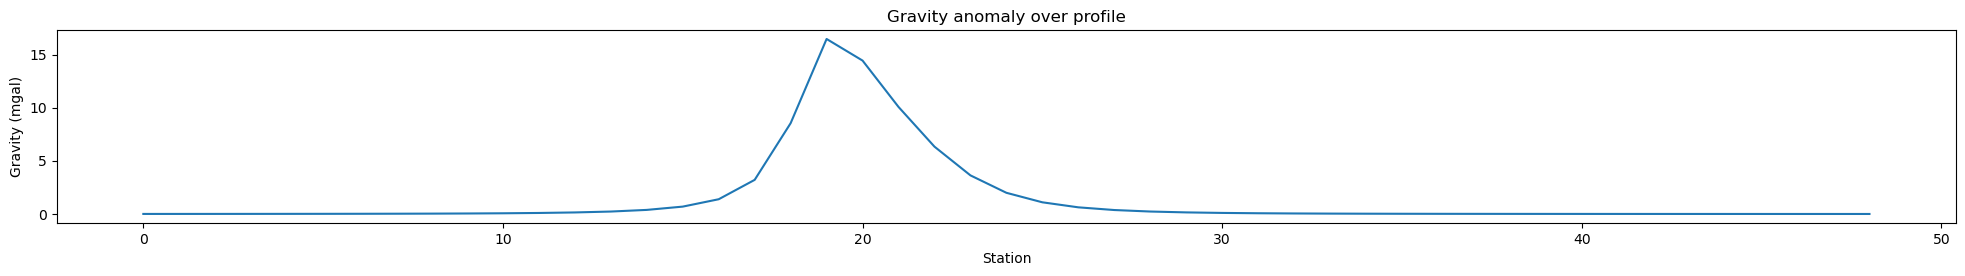

In [104]:
# Plot the values of d_est using PyPlot
fig = figure(figsize=(nx/2,nz/2))
plot(d_est)
xlabel("Station"); ylabel("Gravity (mgal)");
title("Gravity anomaly over profile");
show()

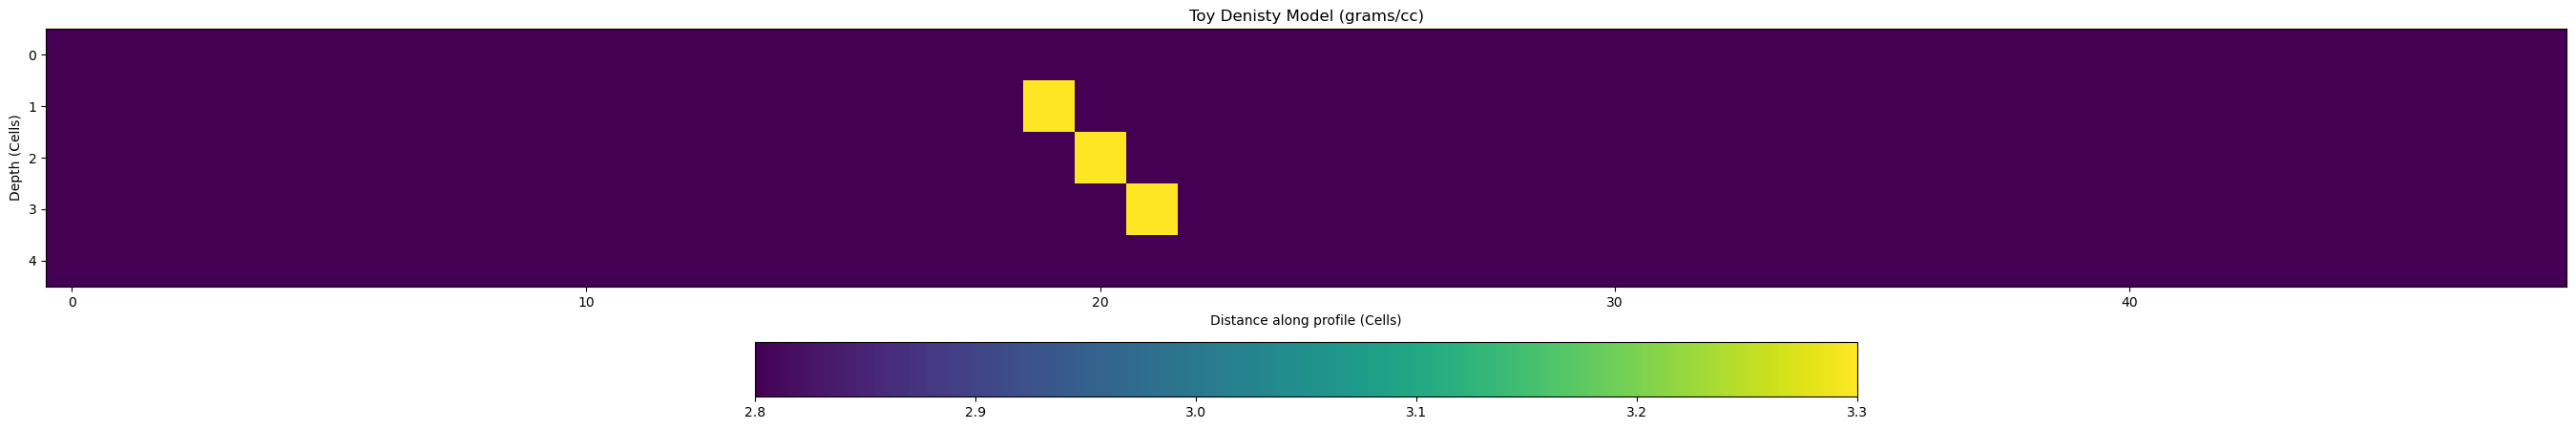

PyObject <matplotlib.colorbar.Colorbar object at 0x7f6a892e4730>

In [102]:
fig = figure(figsize=(nx,nz))
imshow(model .+ background)
xlabel("Distance along profile (Cells)"); ylabel("Depth (Cells)"); title("Toy Denisty Model (grams/cc)")
colorbar(orientation="horizontal")

## Inversion
For this example, the estimated data values from the above forward model, are to be used at the observed values for the following inversion

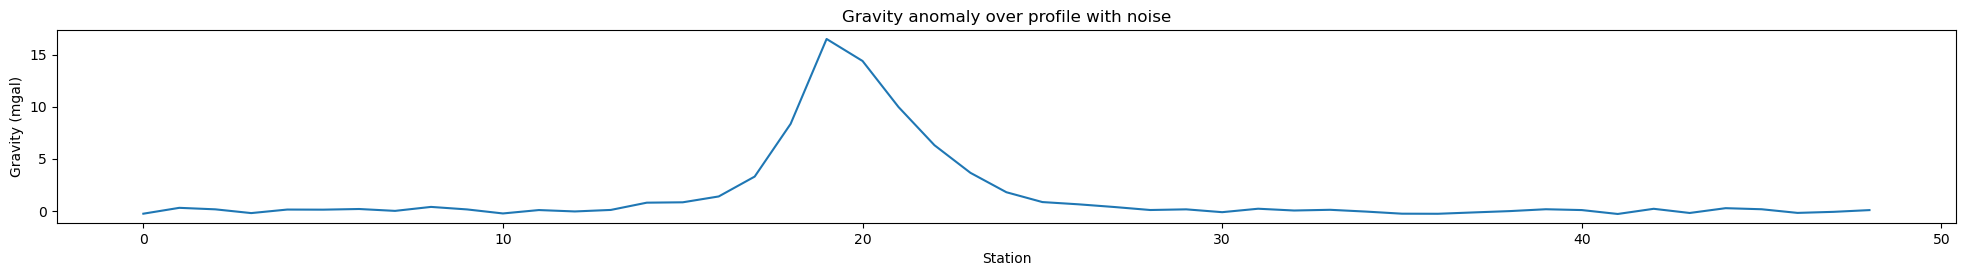

In [138]:
d_obs = d_est;  # Set Observed Values from Estimated
d_obs = d_obs .+ randn(length(d_obs)) * NOISE;
# Plot the values of d_est using PyPlot
fig = figure(figsize=(nx/2,nz/2))
plot(d_obs)
xlabel("Station"); ylabel("Gravity (mgal)"); title("Gravity anomaly over profile with noise")
show()

In [139]:
#SET PARAMETERS
ζ = 0.10; # For smoothness (regularization)
β = 0.50; # For depth weighting
ε = 0.99; # Compactness (minimum area constraint) 
iterations=5;

#***SHOULD NOT NEED TO EDIT BELOW THIS LINE***

# fix for reproducability
Random.seed!(44); println("Random Seed No. '",randstring(),"'\n") 

#get dimensions
M = size(model)[1] * size(model)[2];
N = size(model)[2];

# generate a G with assuming no change in datum height (z)
G = generateKernel(M, zeros(N), dx, dz);

# g_obs = vcat(ones(20) * 4, d_obs);  #zero pad for stability
g_obs = d_obs;



Random Seed No. 'F4IiX48W'

(kernel.jl) the model is 5 by 49

In [140]:
# Make an H matrix "flatness"
H = Matrix{Float64}(I,M,M) * -1; #smoothness matrix
for i = 1:M-1, j = 2:M
    H[i,i+1] = 1;
    #H[j,j-1] = 1;
end

# Make A matrix [G]
############## [H]

A = hcat(G', ζ * H')';

# Make a P matrix ("hard constraint")
P = Matrix{Float64}(I, M, M);

# Make a Q matrix ("depth weighting matrix")
Q = Matrix{Float32}(I, M, M);


for j = 1:M
    Q_jj = 1 / (((j*dz) + ε)^β);
    Q[j,:] = Q[j,:] * Q_jj;
end

# Make a V matrix ("compactness")
𝓥 = Matrix{Float64}(I,M,M); #initially set to Identity

245×245 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [141]:
# Set any initial density anomaly estimates
ρ_back = zeros(M) # Background anomaly is zero

ρ = Array{Float64}(undef,M) .+ ρ_back;
ρ_min = -1;
ρ_max = 1;

null_vector = zeros(M) # Null vector

for i = 1:M # Update hard constraint
    if ρ[i] != 2.5
        P[i,i] = 1e-2
    end
end

In [142]:
for i = 1:iterations
    W = inv(P) * Q * 𝓥
    g_cal = G * ρ
    b = vcat(g_obs - g_cal, null_vector);
    Θ = return_m((A * inv(W)) * transpose((A * inv(W))), b, 40); # C.G.

    global ρ = ρ + (inv(W) * transpose(A * inv(W)) * Θ)

    for j = 1:M
        𝓥[j,j] = 1 / ((ρ[j])^2 + 1e-11)
        if ρ[j] < ρ_min || ρ[j] > ρ_max
            P[j,j] = 1e-2
        else
            P[j,j] = 1
        end
    end
end

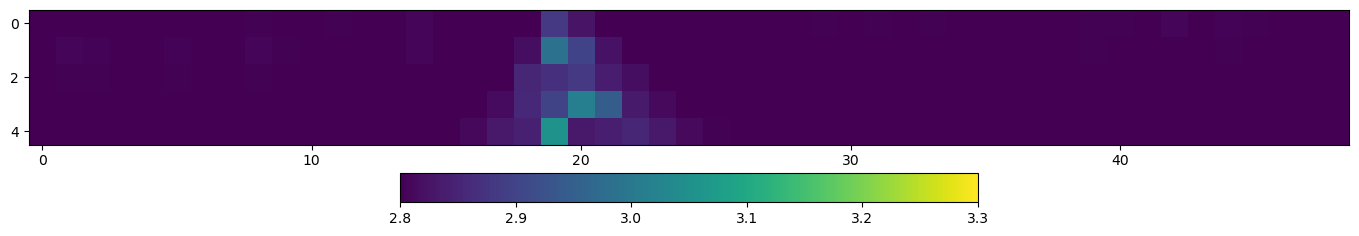

PyObject <matplotlib.colorbar.Colorbar object at 0x7f6a7f030cd0>

In [143]:
model_est = reshape(ρ, (nx, nz)) .+ background

fig = figure(figsize=(nx/2,nz/2))
imshow(transpose(model_est) , vmin=2.8, vmax=3.3)
colorbar(orientation="horizontal")
# npzwrite("m_est.npy", model_est) #write out to a numpy file

The mean squared error betweent he observed and estimated data is: 0.00185

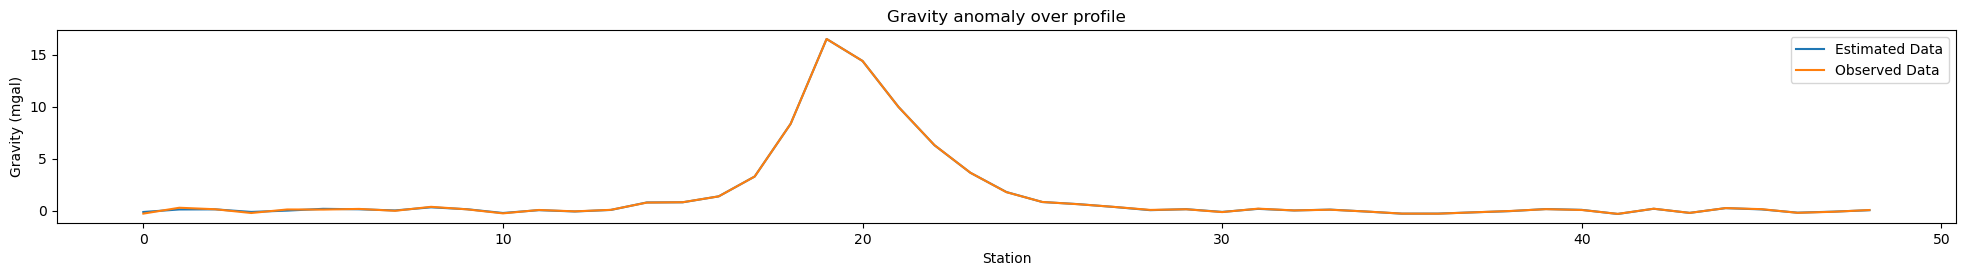

In [144]:
d_estf = G * ρ
mse = sum((d_obs .- d_estf).^2) / length(d_obs) # Calculate Mean Squared Error
print("The mean squared error betweent he observed and estimated data is: ", round(mse, digits=5))
# Plot the values of d_est using PyPlot
fig = figure(figsize=(nx/2,nz/2))
plot(d_estf, label="Estimated Data")
plot(d_obs, label="Observed Data")
xlabel("Station")
ylabel("Gravity (mgal)")
legend()
title("Gravity anomaly over profile")
show()

# End